# Select stations
***

__Author__: Chus Casado<br>
__Date__:   13-02-2023<br>

__Introduction__:<br>
The objectives of this notebook are two:

* To select a subset of study points in the catchment.
* To count the number of flood events that occurred in the catchment during the period from 14-10-2020 and 31-12-2022. 

I consider a flood event each time that the discharge time series goes over the 5-year discharge return period, which is not the same as the number of timesteps at which discharge exceeds the threshod. For every exceeding period, we count one event, no matter if the event lasted 6 h or several days.

To avoid that the correlation between river points affects the result of the EFAS notification skill assessment, I will try different procedures to select study points.

To make the study more comprehensible and to make sure that the data of the reporting points is correct, the whole notebook focuses on the Ebro River catchment.

__Tasks to do__:<br>
* [x] Remove stations too close. 
    * [x] According to area increment between stations in the same river.
    * [x] According to correlation between the discharge timeseries. From each pair of highly correlated stations one must be removed; the election of which one from the pair to remove is important!
    * [x]
    * [x] According to correlation only for highflows. I consider high flow when discharge exceeds the 1.5 return period
    
Possible solutions:
* [x] Apply the correlation procedure event-wise, so that it doesn't eliminate the minor events
* [x] Apply the correlation procedure to the subset of stations with some flood event, so that a station with no events does not remove a highly correlated station that in fact had events.
* Change thresholds:
    * [x] Increase the area increment threshold in order to remove more stations, hence, reduce correlation.
    * [x] Increase the correlation threshold to be more restrictive and remove less stations.Possible solutions:
* [x] Apply the correlation procedure event-wise, so that it doesn't eliminate the minor events
* [x] Apply the correlation procedure to the subset of stations with some flood event, so that a station with no events does not remove a highly correlated station that in fact had events.
* Change thresholds:
    * [x] Increase the area increment threshold in order to remove more stations, hence, reduce correlation.
    * [x] Increase the correlation threshold to be more restrictive and remove less stations.

In [1]:
import os
import glob
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import cartopy.crs as ccrs
import cartopy.feature as cf
from datetime import datetime, timedelta
import seaborn as sns

path_root = os.getcwd()

import warnings
warnings.filterwarnings("ignore")

os.environ['USE_PYGEOS'] = '0'
import geopandas as gpd

os.chdir('../py/')
from notifications import *
os.chdir(path_root)

In [2]:
# correlation threshold
rho = .9

# area threshold
area = 500

In [3]:
# load table of fixed reporting points
stations = pd.read_csv('../data/Station-2022-10-27v12.csv', index_col='station_id')
stations.index = stations.index.astype(str)
# filter stations and fields
mask = (stations['DrainingArea.km2.LDD'] >= area) & (stations.FixedRepPoint == True) & ((stations.EC_calib != 0) & (stations.EC_calib != np.nan))
stations = stations.loc[mask, ['StationName', 'LisfloodX', 'LisfloodY', 'DrainingArea.km2.LDD', 'Catchment', 'River', 'EC_Catchments', 'Country code']]
stations.columns = stations.columns = ['name', 'X', 'Y', 'area', 'subcatchment', 'river', 'catchment', 'country']
stations[['strahler', 'pfafstetter']] = np.nan

# load shapefile with edited river and catchment names
points_edited = gpd.read_file('../data/GIS/fixed_report_points_500.shp')
points_edited.set_index('station_id', inplace=True, drop=True)
points_edited = points_edited[['StationNam', 'LisfloodX', 'LisfloodY', 'DrainingAr', 'Subcatchme',
                               'River', 'Catchment', 'Country co', 'strahler', 'pfafstette']]
points_edited.columns = stations.columns
# select points with a Pfafstetter code
mask = points_edited.pfafstetter.isnull()
points_edited = points_edited.loc[~mask]

# correct names of catchments and rivers
ids = list(set(stations.index).intersection(points_edited.index))
stations = stations.loc[ids]
for id in ids:
    for var in ['subcatchment', 'river', 'catchment']:
        if points_edited.loc[id, var] != np.nan:
            stations.loc[id, var] = points_edited.loc[id, var]

# add subcatchment and river order
stations.loc[ids, ['strahler', 'pfafstetter']] = points_edited.loc[ids, ['strahler', 'pfafstetter']]

# rename columns
#stations.columns = ['name', 'X', 'Y', 'area', 'subcatchment', 'river', 'catchment', 'country', 'strahler', 'subcatchment_order']

print('no. stations:\t{0}'.format(stations.shape[0]))

no. stations:	2038


In [4]:
# shapefile of rivers of Europe
rivers_shp = gpd.read_file(f'../data/GIS/RiversForWebPage_EU_ready.shp')


DANUBE
------

ELBE
----

ODER
----

RHINE
-----

SOCA
----

KEMIJOKI
--------

TORNE
-----

TANA
----

PAATSJOKI
---------

UMEALVEN
--------

SCHELDT
-------

VISTULA
-------

GLOMMA
------

DRAMMEN
-------

GUADIANA
--------

TAGUS
-----

PO
--

RHONE
-----

PREGOLYA
--------

EVROS
-----

EBRO
----

NARVA
-----

GUADALHORCE
-----------

ANDARAX
-------

GUADALQUIVIR
------------

GUADIARO
--------

GARONNE
-------

SEINE
-----

GOTA
----

NAMSEN
------

ORKLA
-----

LAGEN
-----

DRIVA
-----

GAULA
-----

RAUMA
-----

SKIEN
-----

VEFSNA
------

ALTAELVA
--------

DAUGAVA
-------

LLOBREGAT
---------

DOURO
-----

PITEALVEN
---------

DAL
---

HELGE
-----

RANEALVEN
---------

KALIX
-----

SKELLEFTEALVEN
--------------

INDALSALVEN
-----------

ARBOGAAN
--------

MINHO
-----

LIMA
----

DNIESTER
--------

DNIEPER
-------

TAY
---

FORTH
-----

CLYDE
-----

NITH
----

TWEED
-----

DEE
---

BOYNE
-----

SLANEY
------

BARROW
------

BLACKWATER
----------

SHANNON
-------

CORRIB
----

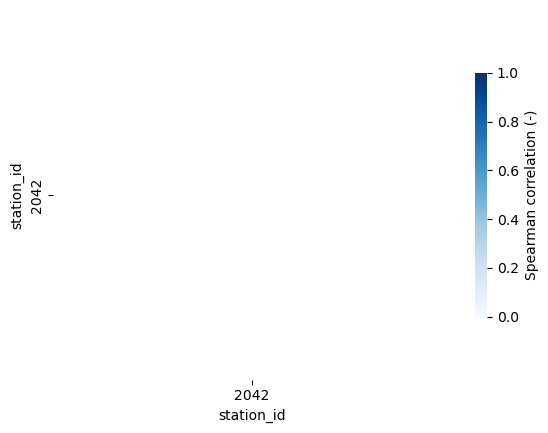

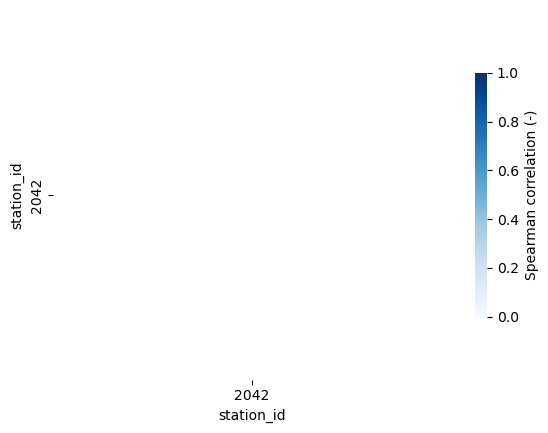

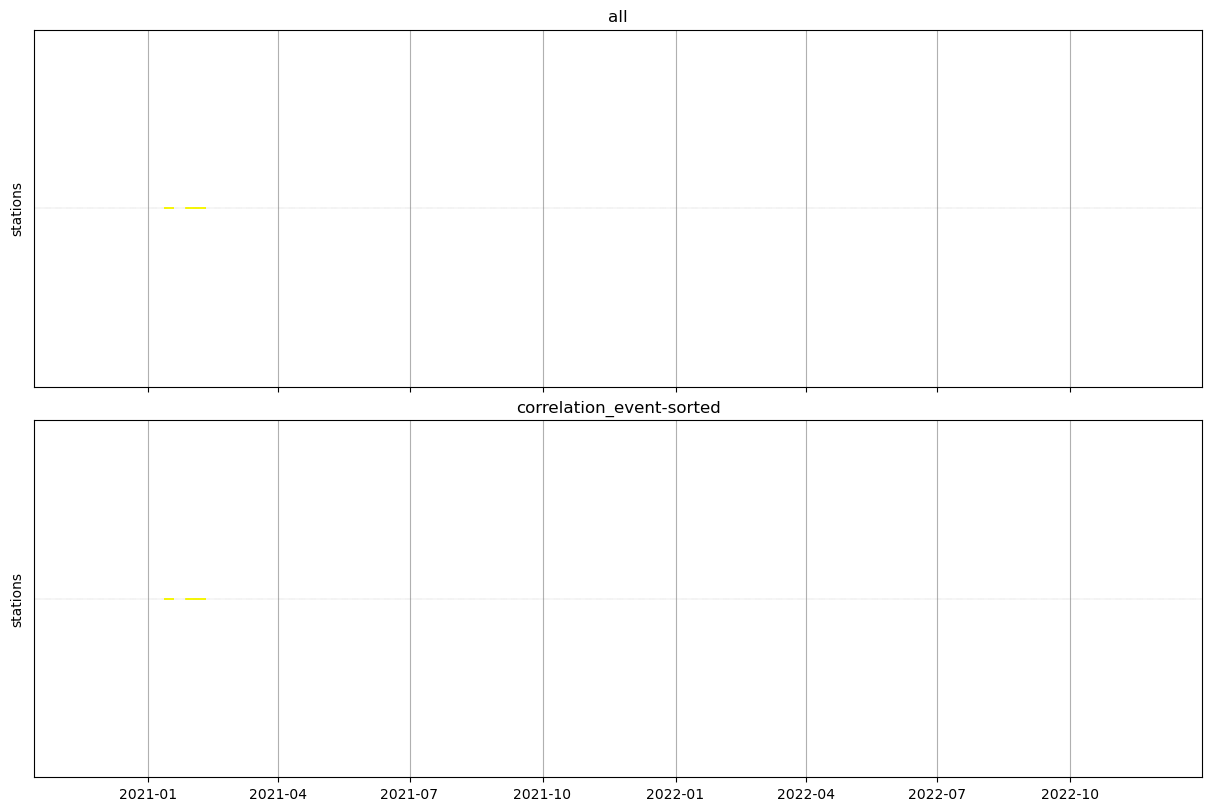

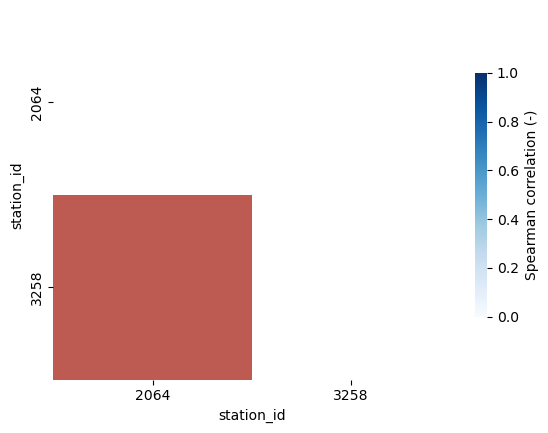

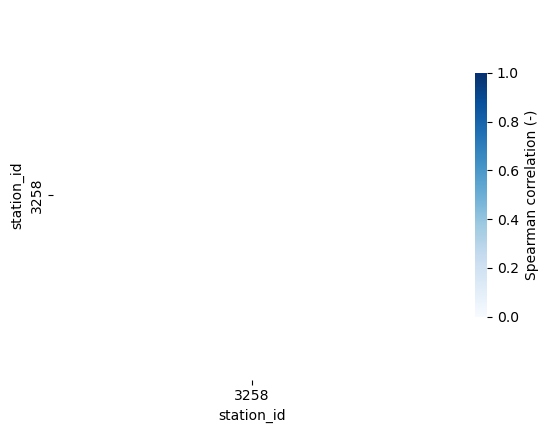

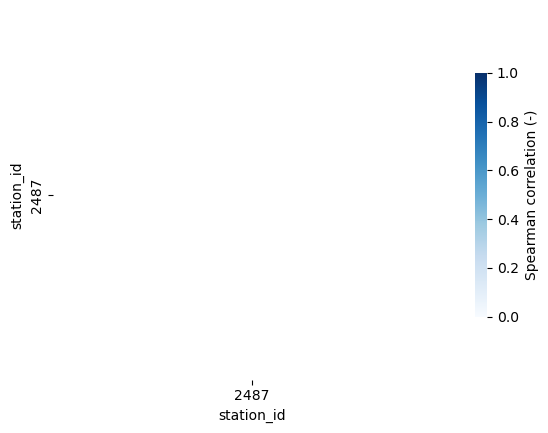

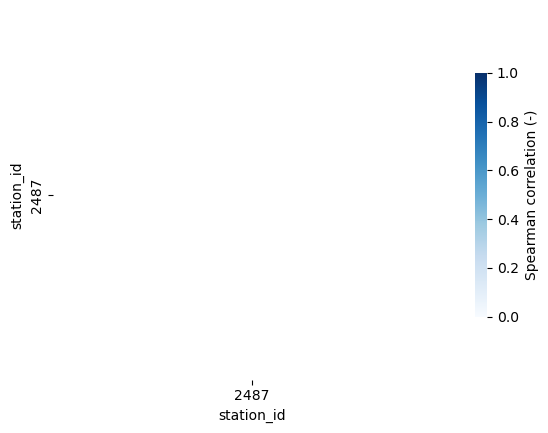

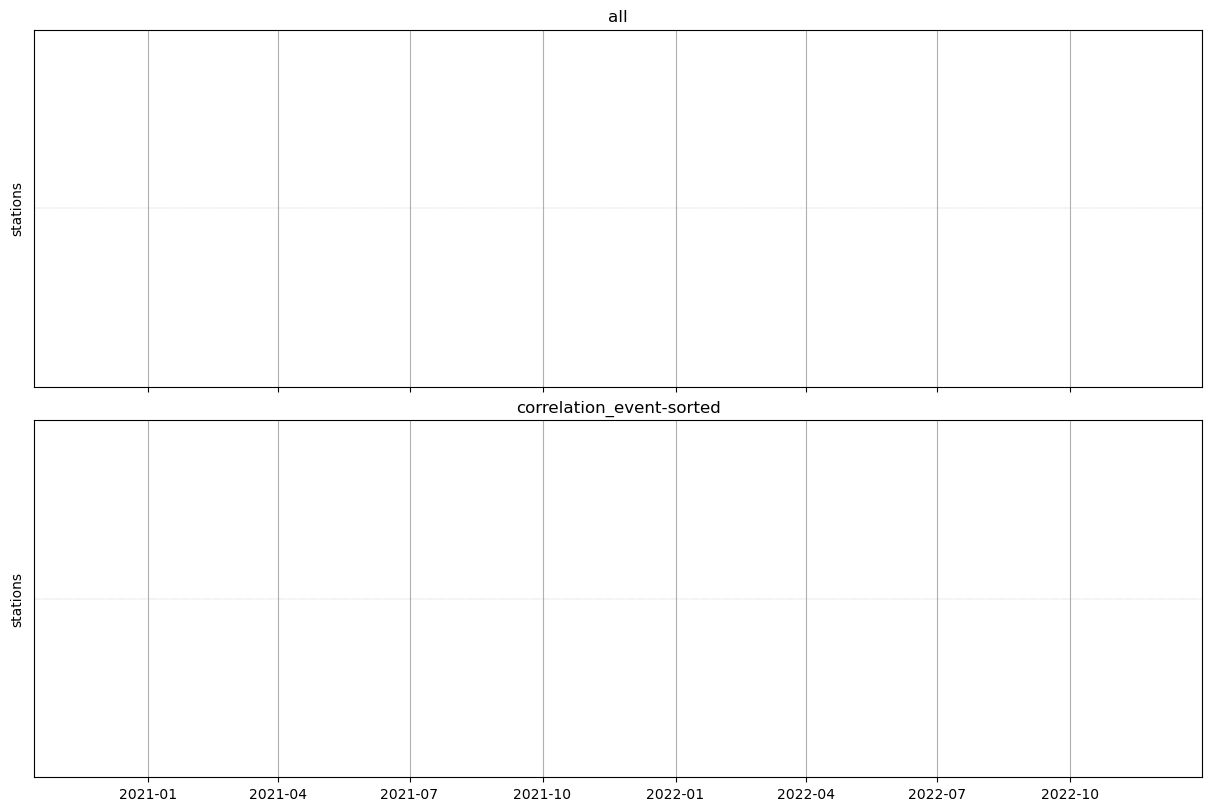

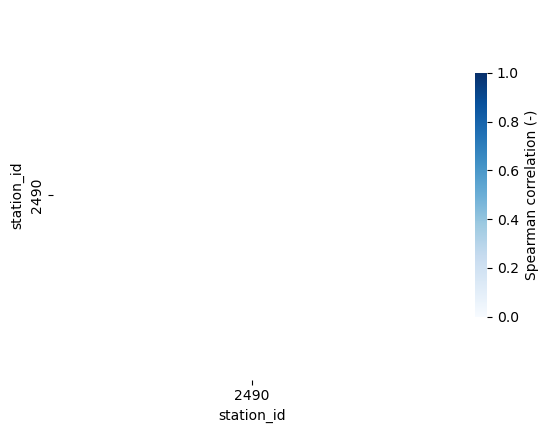

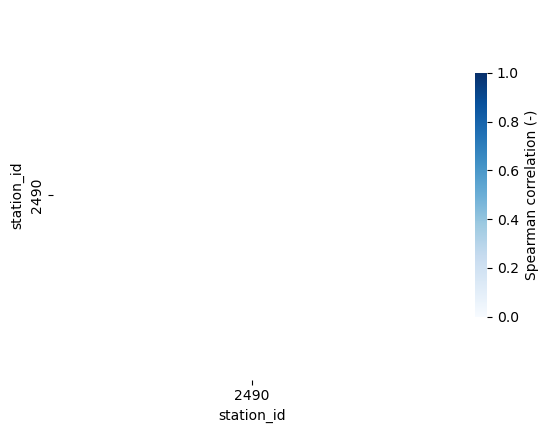

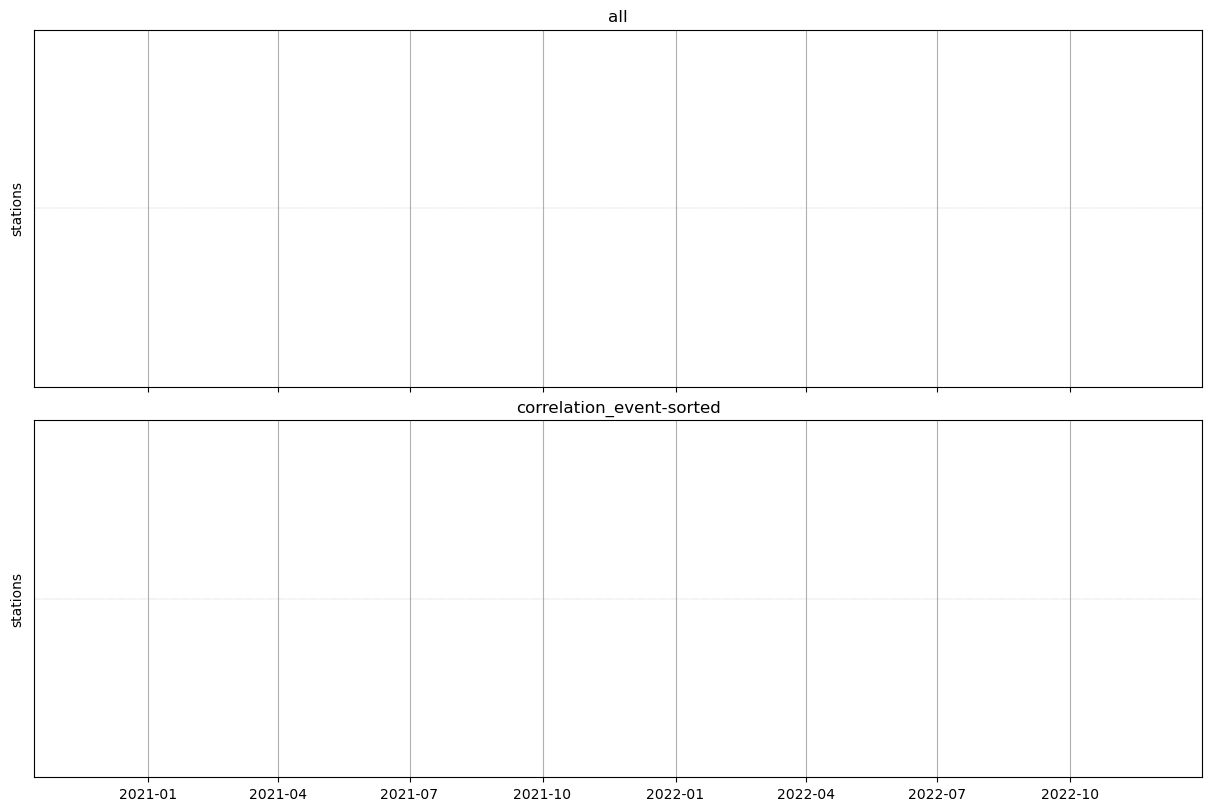

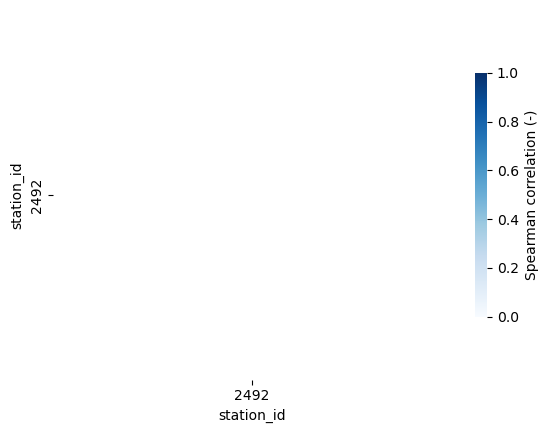

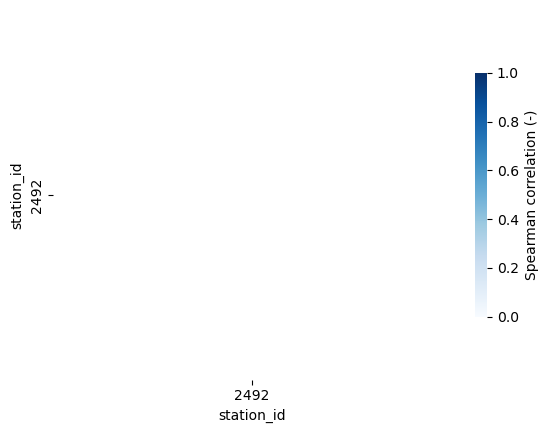

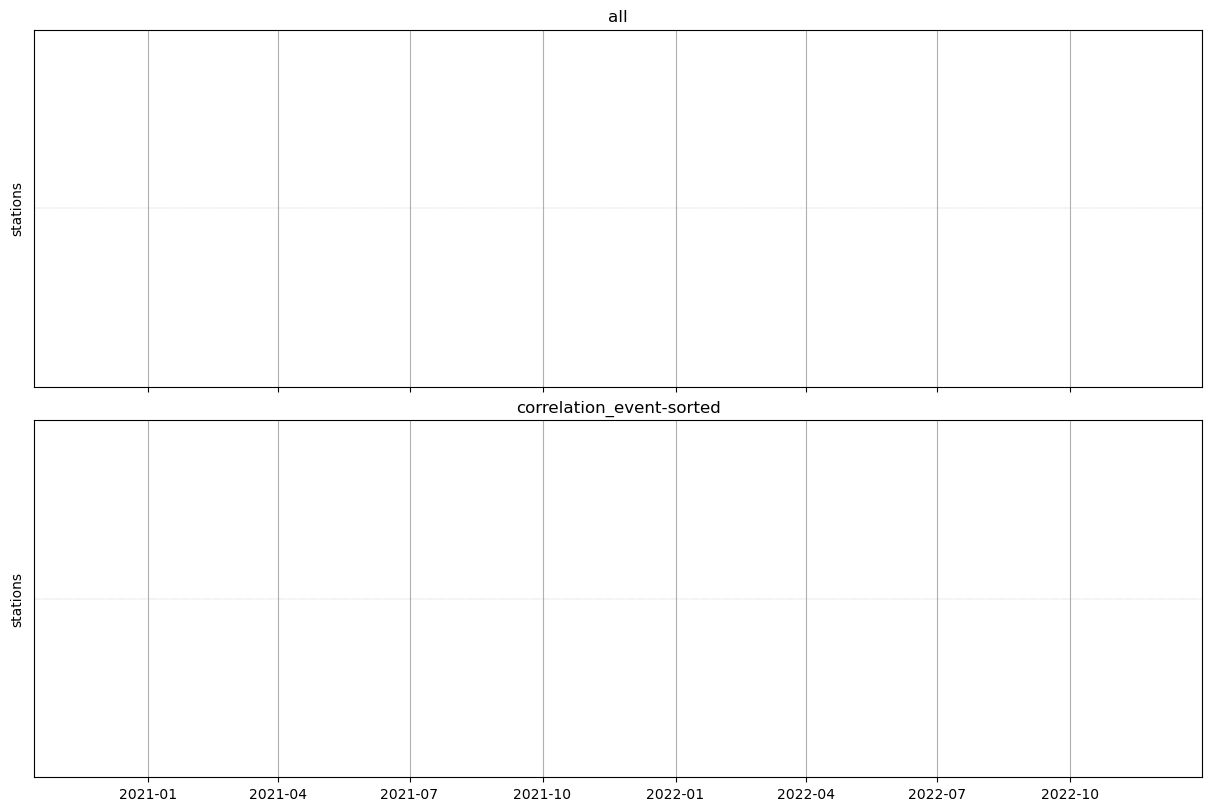

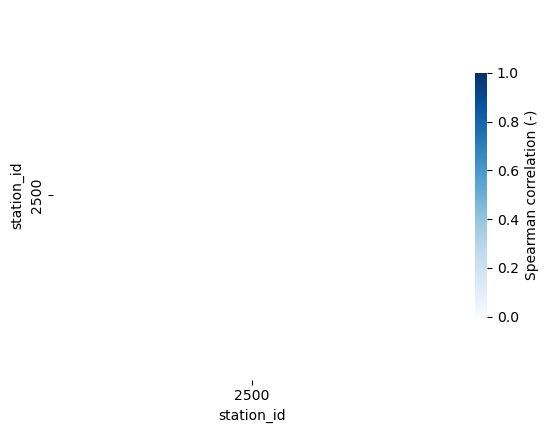

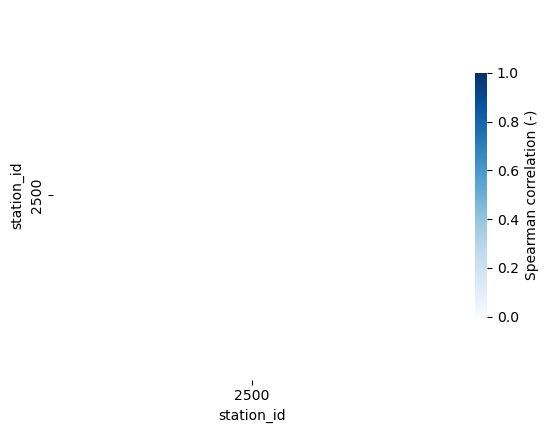

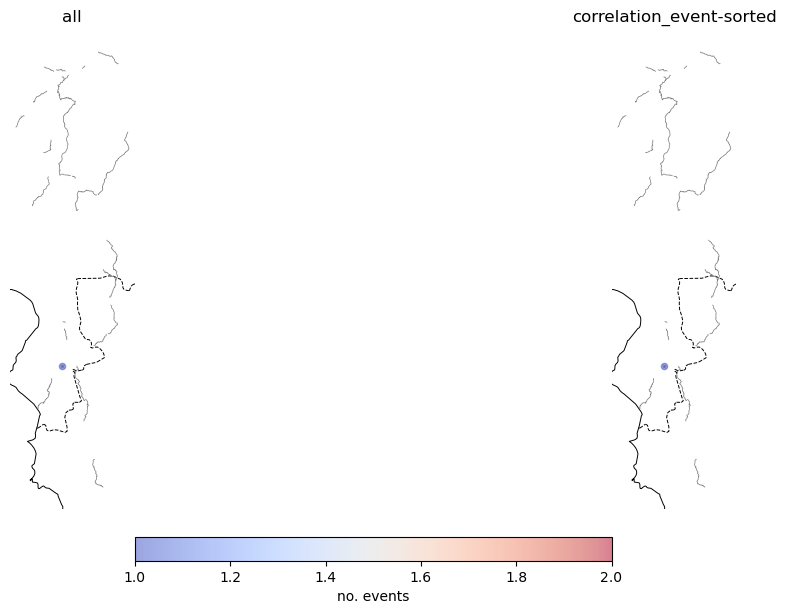

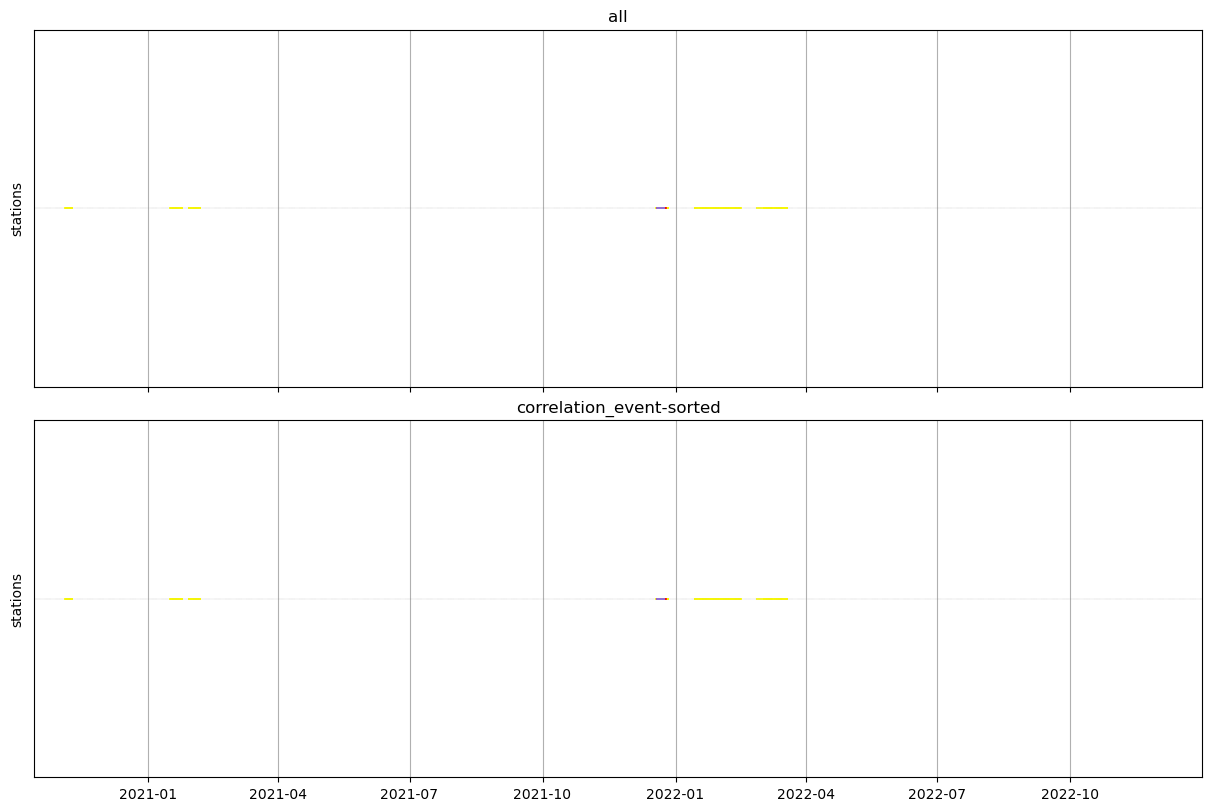

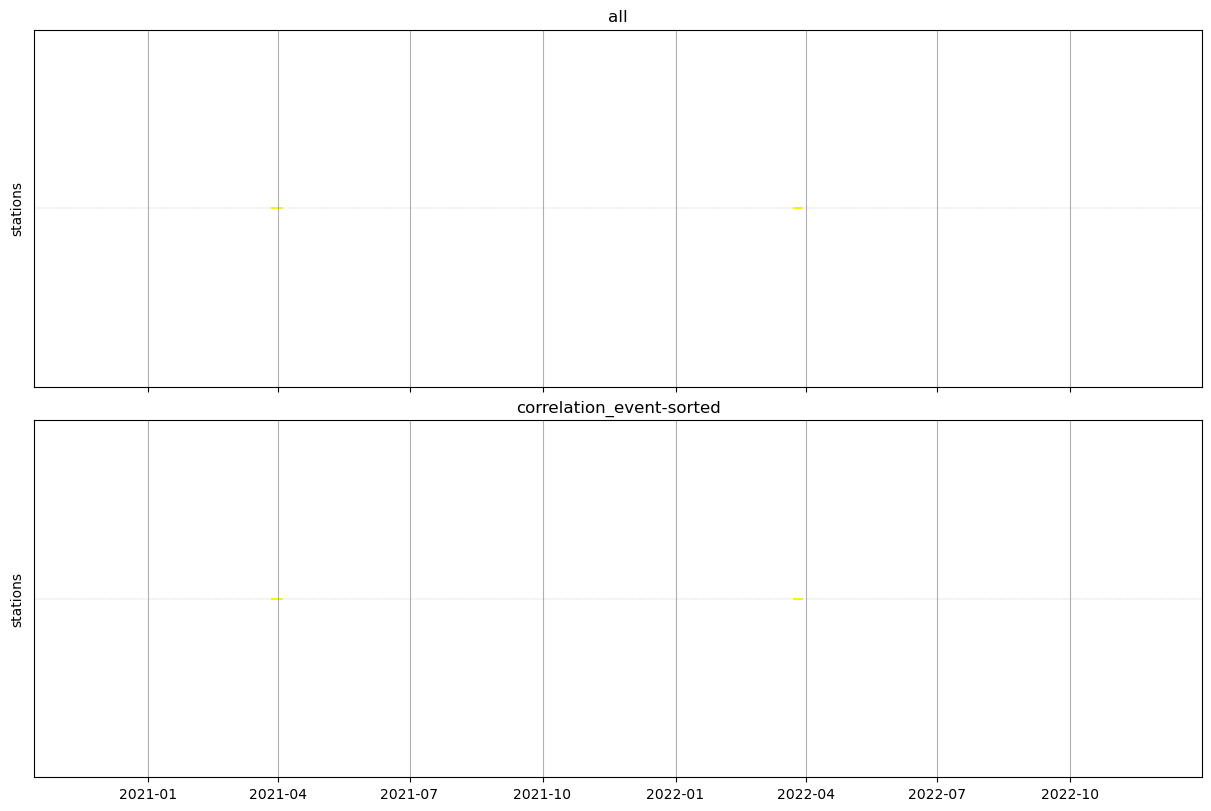

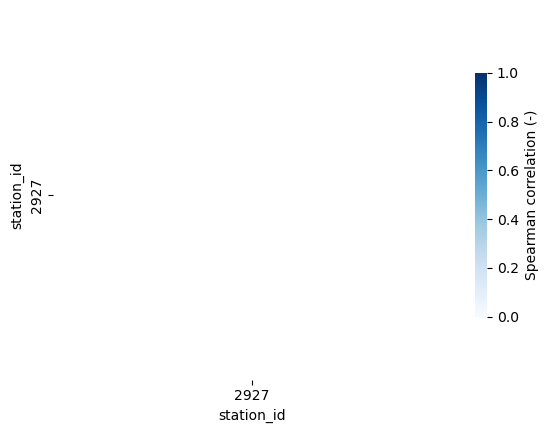

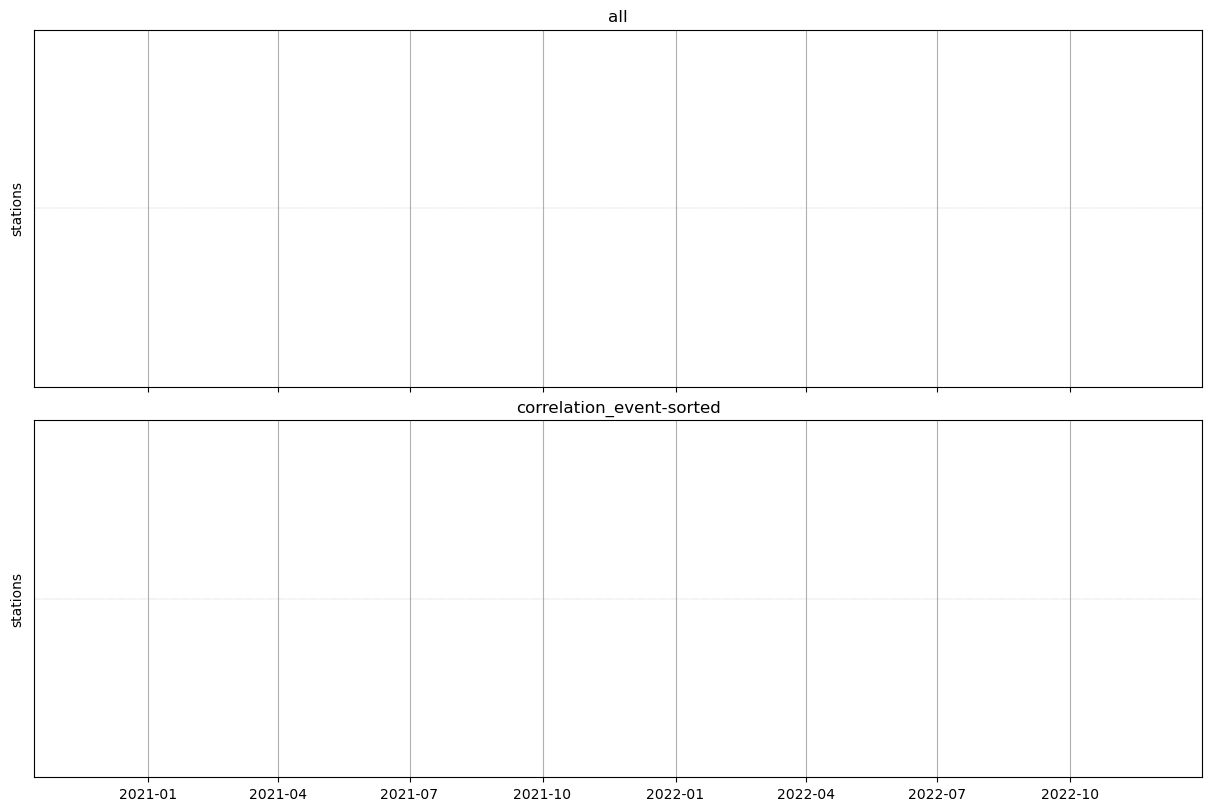

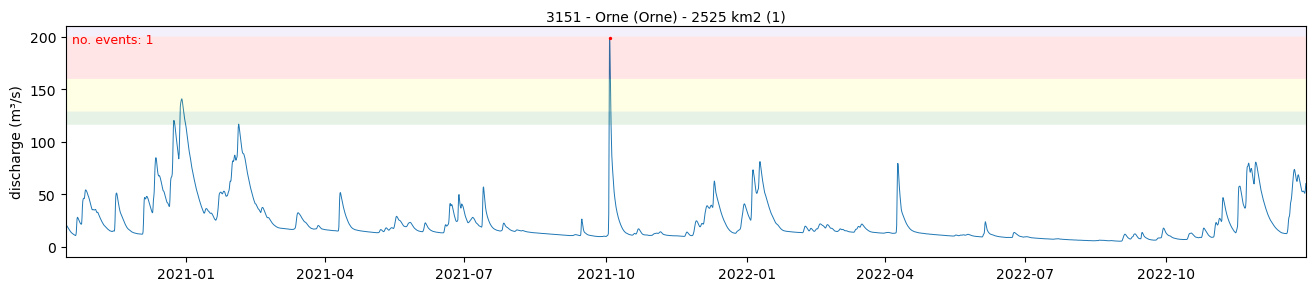

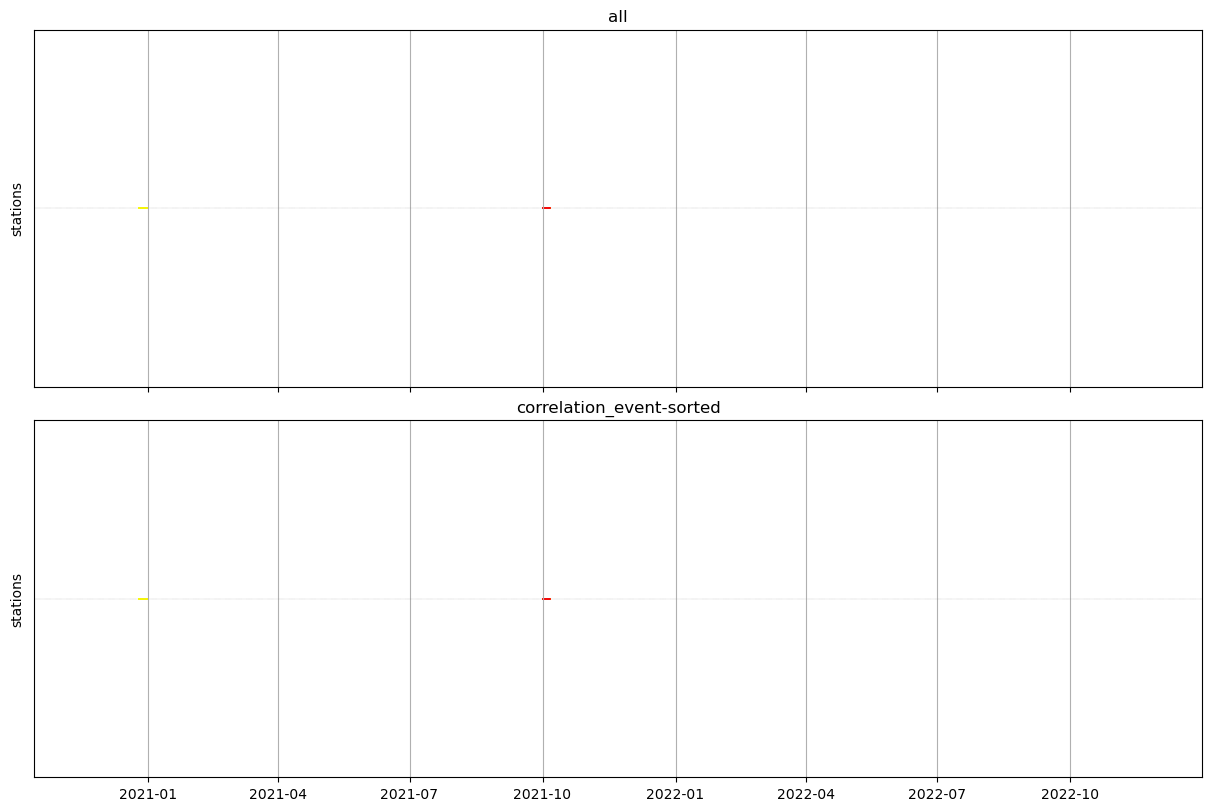

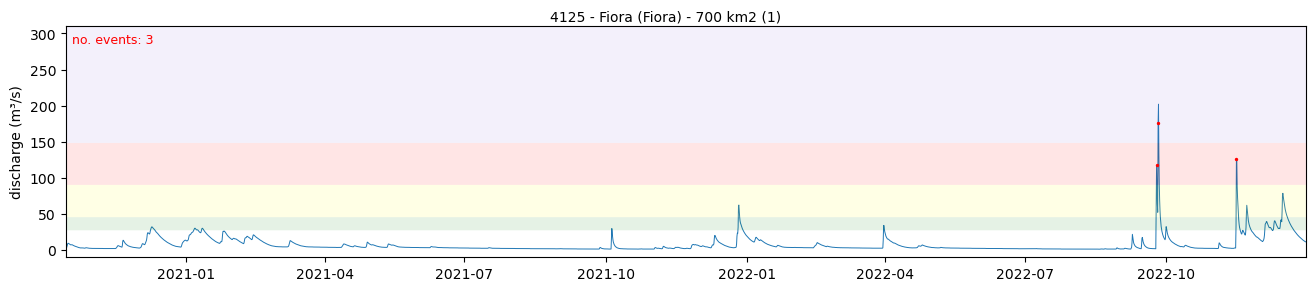

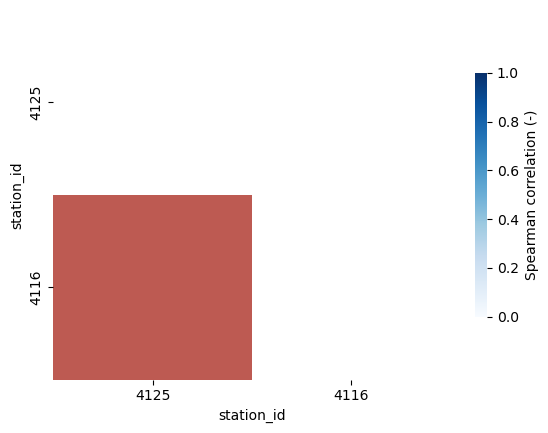

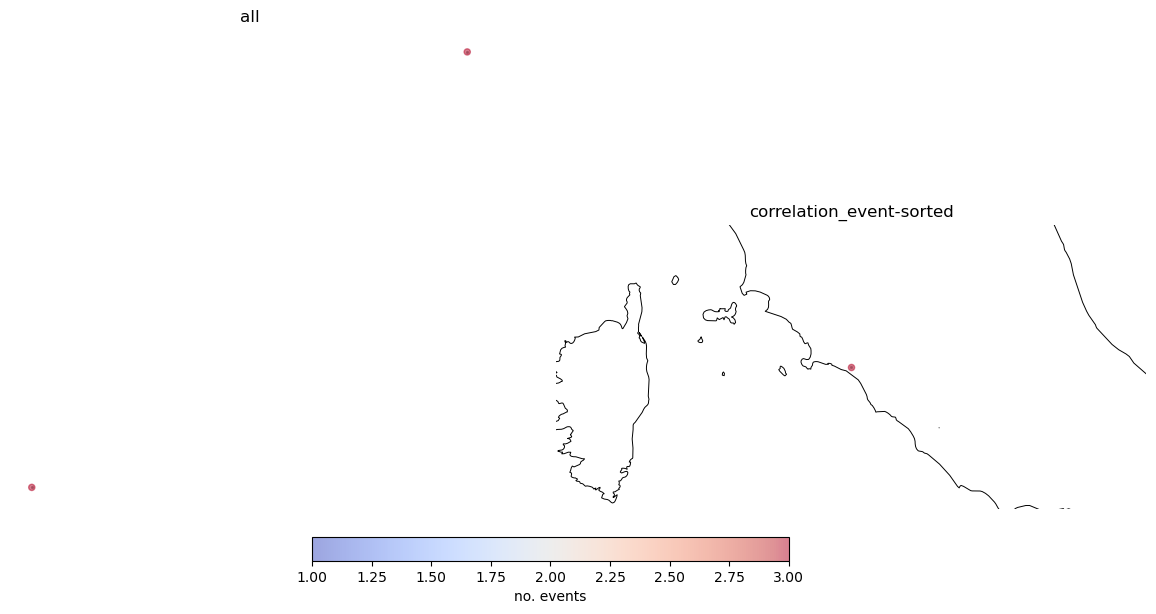

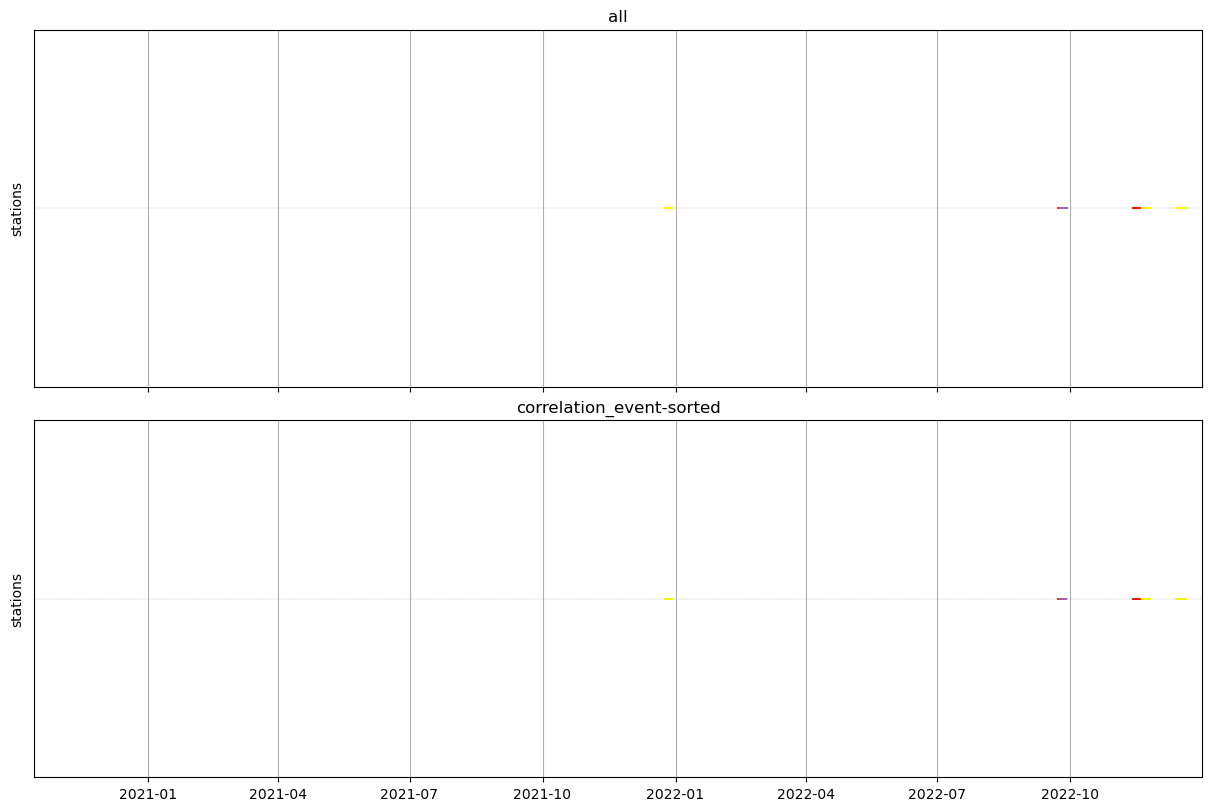

In [5]:
# catchments = ['Liri', 'Evros', 'Strimonas', 'Drin', 'Kuban', 'Kymijoki', 'Dal', 'Gota', 'Arbogaan',
#               'Ljusnan', 'Ljungan', 'Indalsalven', 'Angermanalven', 'Umealven', 'Skelleftealven', 
#               'Pitealven', 'Lueleaelven', 'Ranealven', 'Kalix', 'Torne', 'Ikjoki', 'Oulujoki',
#               'Kokem', 'Drammen', 'Lagen', 'Skien', 'Lagarfljot', 'Jkuls Fjllum', 'Skjalfandafljot',
#               'Heradsvotn', 'Hvita', 'Oelfusa', 'Kola', 'Paatsjoki', 'Tana', 'Altaelva', 'Vefsna',
#               'Namsen', 'Gaula', 'Driva', 'Rauma', 'Helge', 'Parnu', 'Lielupe', 'Scheldt', 'Mondego']

catchments = points_edited.catchment.unique()

for catchment in catchments:
    
    print(f'\n{catchment.upper()}')
    print('-' * len(catchment))

    out_folder = f'results/{catchment}/'
    if os.path.exists(out_folder) is False:
        os.makedirs(out_folder)
    else:
        continue

    # extract stations in the catchment
    stn_cat = stations.loc[stations.catchment == catchment].copy()
    stn_cat.sort_values(['area'], ascending=True, inplace=True)
    stn_cat.sort_values('pfafstetter', ascending=False, inplace=True)
    print('no. stations in the {0} catchment:\t{1}'.format(catchment, stn_cat.shape[0]))

    # shapefile with rivers
    rivers_cat = rivers_shp.loc[rivers_shp.BASIN == catchment]

    # load thresholds and extract 5-year discharge
    path_reanalysis = f'../data/thresholds/'
    thresholds = xr.open_dataset(f'{path_reanalysis}return_levels.nc')

    # coordinate arrays necessary to extract the data
    x = xr.DataArray(stn_cat.X, dims='id')
    y = xr.DataArray(stn_cat.Y, dims='id')

    # extract thresholds for each return period and station
    variables = list(thresholds.keys())
    for var in variables:
        # extract X-year discharge for the stations
        da = thresholds[var].sel(x=x, y=y, method='nearest')

        # add threshold to the stations data frame
        stn_cat[var] = da.data

    # load discharge reanalysis data
    files = glob.glob(f'../data/discharge/reanalysis/*202*.csv')
    if 'dis' in locals():
        del dis
    for file in files:
        temp = pd.read_csv(file, parse_dates=True, index_col=0)
        if 'dis' in locals():
            dis = pd.concat((dis, temp), axis=0)
        else:
            dis = temp.copy()
        del temp

    # cut the timeseries from 14-10-2020 12 pm and the selected reporting points
    dis_cat = dis.loc['2020-10-14 12:00:00':, stn_cat.index]

    print('Discharge timeseries:\n{0}\ttimesteps\n{1}\tstations'.format(*dis_cat.shape))

    # return period
    rp = 5

    # IDENTIFY EVENTS
    # ---------------

    # identify events only with upper bound
    events = identify_events(dis_cat, stn_cat[f'rl{rp}'])

    # count number of events per station
    col = f'n_events_{rp}'
    stn_cat[col] = events.sum()
    print('no. stations with at least one event:\t{0}'.format((stn_cat[col] > 0).sum()))
    print('total no. events:\t\t\t{0}'.format(stn_cat[col].sum()))


    if events.sum().sum() > 0:

        # PLOT MAP
        # # --------
        # plt.figure()
        # plot_events_map(stn_cat.X, stn_cat.Y, stn_cat[col], rivers=rivers_cat, size=20)

        # PLOT TIMESERIES
        # ---------------

        # Select the stations in a catchment
        mask = stn_cat[col] > 0
        stns = stn_cat.loc[mask].index#.sort_values(['subcatchment_order', 'strahler']).index
        # plot timeseries 
        for stn in stns:
            title = '{0} - {1} ({2}) - {3:.0f} km2 ({4:.0f})'.format(stn, *stn_cat.loc[stn, ['river', 'subcatchment', 'area', 'pfafstetter']])
            plot_events_timeseries(dis_cat[stn], events[stn], thresholds=stn_cat.loc[stn, ['rl1.5', 'rl2', 'rl5', 'rl20']],
                                   title=title, save=f'{out_folder}/no_events_{stn}.png')

    # correlation matrix
    corr = dis_cat.corr(method='spearman')
    # keep only upper diagonal
    corr = filter_correlation_matrix(corr, rho=None)

    # compute exceedance of the correlation threshold
    highly_correlated = corr > rho
    highly_correlated = highly_correlated.astype(int)
    highly_correlated[highly_correlated == 0] = np.nan

    # plot
    plt.figure()
    sns.heatmap(corr, vmin=0, vmax=1, cmap='Blues', cbar_kws={'label': 'Spearman correlation (-)', 'shrink': .66});
    sns.heatmap(highly_correlated, cmap='Reds', vmin=0.5, vmax=1.5, alpha=.75, cbar=None);

    # sort stations according to number of flood events
    stn_cat_3 = stn_cat.copy()
    stn_cat_3.sort_values([col], ascending=True, inplace=True)

    # correlation matrix
    corr_3 = dis_cat[stn_cat_3.index.to_list()].corr(method='spearman')
    # remove highly correlated stations
    corr_3 = filter_correlation_matrix(corr_3, rho=rho)
    stn_cat_3 = stn_cat_3.loc[corr_3.index]

    print('no. original points in the {0} catchment:\t{1}'.format(catchment, stn_cat.shape[0]))
    print('no. filtered points in the {0} catchment:\t{1}'.format(catchment, stn_cat_3.shape[0]))
    
    plt.figure()
    sns.heatmap(corr_3, vmin=0, vmax=1, cmap='Blues',
                cbar_kws={'label': 'Spearman correlation (-)', 'shrink': .66});

    stn_sets = {'all': stn_cat,
                'correlation_event-sorted': stn_cat_3}

    # sort all subsets equally
    for key, stns in stn_sets.items():
        stns.sort_values(['area'], ascending=True, inplace=True)
        stns.sort_values('pfafstetter', ascending=False, inplace=True)

    # table summarizing no. stations and events with every station set
    summary = pd.DataFrame(index=stn_sets.keys(), columns=['no_stations', 'p_stations_event', 'no_events'])
    for i, (key, stns) in enumerate(stn_sets.items()):
        summary.loc[key] = stns.shape[0], sum(stns[col] > 0), stns[col].sum()
    summary.p_stations_event /= summary.no_stations
    print(summary)

    if events.sum().sum() > 0:
        # plot maps of no. events for each of the station sets
        proj = ccrs.LambertAzimuthalEqualArea(central_longitude=10, central_latitude=52, false_easting=4321000, false_northing=3210000,
                                                  globe=ccrs.Globe(ellipse='GRS80'))
        nrows = 1
        ncols = int(np.ceil(len(stn_sets) / nrows))
        fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(6 * ncols, 6 * nrows), 
                                 subplot_kw={'projection': proj}, constrained_layout=True)
        vmax = max(stn_sets['all'][col].max(), 2)
        for ax, (key, stns) in zip(axes.flatten(), stn_sets.items()):
            plot_events_map(stns.X, stns.Y, stns[col], rivers=rivers_cat, size=20, ax=ax, title=key, vmax=vmax, cbar=True)
        plt.colorbar(plot_events_map.colorbar, location='bottom', shrink=.4, label='no. events', ax=axes[:])
        plt.savefig(f'{out_folder}/no_events_map_{key}.png', dpi=300, bbox_inches='tight')
    
    # plot timeline of threshold exceedances
    fig, axes = plt.subplots(nrows=2, figsize=(12, 8), constrained_layout=True, sharex=True, sharey=True)
    thrs = ['rl2', 'rl5', 'rl20']
    for ax, (key, stns) in zip(axes, stn_sets.items()):
        exceedances_timeline(dis_cat, stns, thresholds=thrs, grid=True, title=key, ax=ax)
    plt.savefig(f'{out_folder}/exceedance_timeline.png', dpi=300, bbox_inches='tight')

    # export selected points
    stn_sets['correlation_event-sorted'].to_csv(f'results/{catchment}/points_selected.csv')